In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Inspect the tables in database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Inspect the content of measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


## Precipitation Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data

# Select the last date in the table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year = int(last_date[0][0:4])
month = int(last_date[0][5:7])
day = int(last_date[0][8:10])

# Estimate tha date a year before last date
last_d = dt.date(year, month, day)
first_d = last_d - dt.timedelta(days=365)

# A query to retrive data (date, prcp) for the last year
sel = [Measurement.date, Measurement.prcp]
prcp_range = session.query(*sel).filter(Measurement.date>=first_d).filter(Measurement.date<=last_d).all()

# A DataFrame to hold the data retrieve from table measurement, sorted by date
mea_df = pd.DataFrame(prcp_range, columns=["date", "precipitation"]).dropna(how='any').sort_values("date").reset_index(drop=True)
mea_df.set_index('date')
mea_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.02
2,2016-08-23,0.05
3,2016-08-23,0.70
4,2016-08-23,0.15


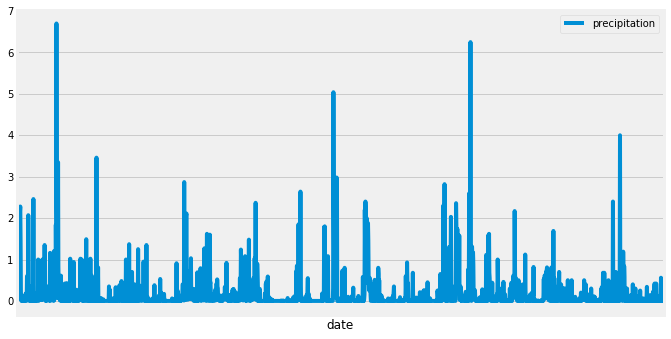

In [13]:
# Plot the results using the DataFrame plot method
mea_df.plot('date', 'precipitation', figsize=(10,5))
plt.tight_layout()
plt.xticks([])
plt.grid(b=True)
plt.savefig("precipitation.png")
plt.show()

In [14]:
# Use Pandas to print the summary statistics for the precipitation data
mea_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [15]:
# Inspect the content of station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to show how many stations are available in this dataset?
station_uniq = session.query(func.count(Station.station)).all()
station_uniq

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order
active = session.query(Measurement.station, func.count(Measurement.station)). \
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel1 = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
most_active = session.query(*sel1).filter(Measurement.station=='USC00519281').all()
most_active

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations
active_tobs = session.query(Measurement.station, func.count(Measurement.tobs)). \
            group_by(Measurement.station).filter(Measurement.tobs!='NaN'). \
            order_by(func.count(Measurement.station).desc()).all()
active_tobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Query the last 12 months of temperature observation data for this station
tobs_last = session.query(Measurement.tobs).filter(Measurement.date>first_d).filter(Measurement.date<last_d). \
            filter(Measurement.station=='USC00519281').filter(Measurement.date<last_d).all()
tobs_last1 = []
for item in tobs_last:
    tobs_last1.append(item[0])


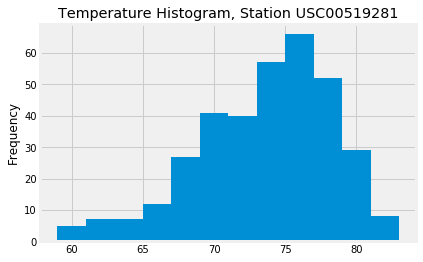

In [21]:
# and plot the results as a histogram
plt.hist(tobs_last1, bins=12)
plt.title('Temperature Histogram, Station USC00519281')
plt.ylabel('Frequency')
plt.savefig("Temp_Observed_Histogram.png")
plt.show()

# Opcional: Other Recommended Analysis

## Temperature Analysis I

In [22]:
# Temperature analisys I
# Identify the average temperature in June at all stations across all available years in the dataset.
# Do the same for December temperature.
tavg_june = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '06'). \
            group_by(func.strftime("%Y", Measurement.date)).all()

tavg_december = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '12'). \
            group_by(func.strftime("%Y", Measurement.date)).all()
tavg_december

[(70.20851063829787),
 (70.82062780269058),
 (71.18807339449542),
 (71.09401709401709),
 (69.89686098654708),
 (73.42391304347827),
 (71.13)]

In [23]:
# Use the t-test to determine whether the difference in the means,
# if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

(t_stat, p) = stats.ttest_ind(tavg_june, tavg_december, equal_var=False)
if p < 0.05:
    print(f"T-test statistics is {t_stat} and p-value is {p}")
    print("Diference in the means is statistically significant")
else:
    print(f"T-test statistics is {t_stat} and p-value is {p}")
    print("Diference in the means is due to chance")


T-test statistics is [6.92185717] and p-value is [1.45188304e-05]
Diference in the means is statistically significant


#### We used an unpaired t-test beacause we dealed with two different months

## Temperatures Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
ini_date = '2016-08-01'
las_date = '2016-08-15'
calc_temper = calc_temps(ini_date, las_date)
calc_tmin, calc_tavg, calc_tmax = calc_temper[0]
calc_tmax

83.0

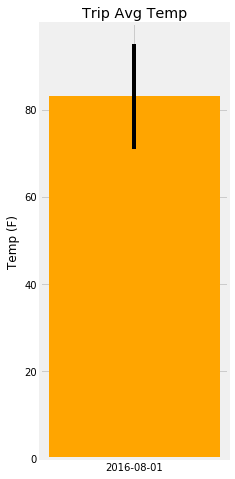

In [26]:
# Plot the min, avg, and max temperature from your previous query as a bar chart
# Use "Trip Avg Temp" as your Title
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
plt.figure(figsize=(3,8))
plt.bar(ini_date, calc_tmax, yerr=calc_tmax-calc_tmin, color='orange')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.savefig("Temp_Stat_LastYear_Vavation.png")
plt.show()

## Daily Rainfall Average

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel2 = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

totalRain_lastDates = session.query(*sel2).filter(Station.station==Measurement.station). \
                    filter(Measurement.date>=ini_date).filter(Measurement.date<=las_date).group_by(Station.station). \
                    order_by(func.sum(Measurement.prcp).desc()).all()
totalRain_lastDates

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.809999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  6.759999999999997),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.35),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.3200000000000003),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.1600000000000001),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.5900000000000001),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.18)]

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# Set the start and end date of the trip. Come from previous steps
y1 = int(ini_date[0:4])
m1 = int(ini_date[5:7])
d1 = int(ini_date[8:10])
y2 = int(las_date[0:4])
m2 = int(las_date[5:7])
d2 = int(las_date[8:10])

# Use the start and end date to create a range of dates
start_date = dt.date(y1,m1,d1)
end_date = dt.date(y2,m2,d2+1)
date_range = [start_date + dt.timedelta(days=x) for x in range(0, (end_date-start_date).days)]

# Stip off the year and save a list of %m-%d strings
normals = []
dates = []
for norm in date_range:
    normals.append(norm.strftime("%m-%d"))
    dates.append(norm.strftime("%Y-%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
normal_days = []
for date in normals:
    normal_days.append(*daily_normals(date))
print(normal_days)

[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0), (68.0, 76.5576923076923, 83.0), (69.0, 75.98039215686275, 81.0), (65.0, 76.42, 83.0), (67.0, 75.98113207547169, 82.0), (67.0, 76.52727272727273, 83.0), (71.0, 76.98245614035088, 84.0), (71.0, 76.77777777777777, 82.0), (69.0, 76.47169811320755, 83.0)]


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_days_df = pd.DataFrame(normal_days, columns=["tmin", "tavg", "tmax"], index=dates)
normal_days_df.head()

,tmin,tavg,tmax
2016-08-01,67.0,75.540000,83.0
2016-08-02,68.0,75.603774,84.0
2016-08-03,70.0,76.611111,85.0
2016-08-04,69.0,76.711538,84.0
2016-08-05,69.0,76.148148,82.0


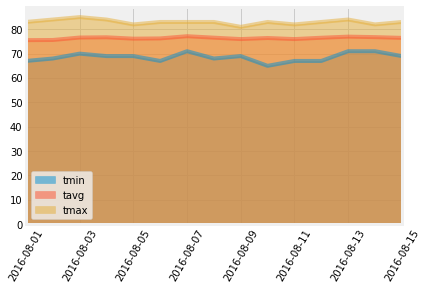

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
normal_days_df.plot.area(stacked=False)
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
#plt.savefig("Min_Avg_Max_LastYear.png")
plt.savefig("Min_Avg_Max_LastYear.png")
plt.show()

In [32]:
j=12